Data analysis for the Franck-Hertz experiment

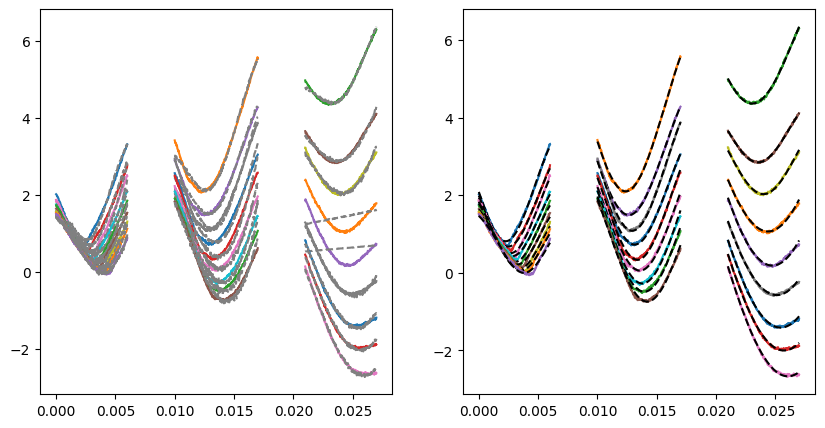

In [88]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

avgs = pd.DataFrame()
vals = [6, 65, 7, 75, 8, 85, 9, 95, 10]
plt.figure(figsize = (10,5))
for m in vals:

    # read all 5 iterations of the same measurement
    datas_1 = pd.DataFrame(); datas_2 = pd.DataFrame()
    for i in range(0, 5):
        # for channel 1
        data = pd.read_csv(str("data/scov" + str(m) + "_0" + str(i+1) + ".csv"), skiprows = [1])
        datas_1.insert(0, str(i), data["1"])
        datas_2.insert(0, str(i), data["2"])

    # compute mean and sd of the measurements
    res_1 = pd.concat([datas_1.mean(axis = 1), datas_1.std(axis = 1)], axis = 1)
    res_2 = pd.concat([datas_2.mean(axis = 1), datas_2.std(axis = 1)], axis = 1)
    res_m = res_1.join(res_2, lsuffix = "_2")
    res_m.columns = ["mean_1", "sd_1", "mean_2", "sd_2"]
    # create label with decimal point
    if "5" in str(m):
        m_lab = str(str(m)[0] + "." + str(m)[1])
    else:
        m_lab = str(m)
    res_m.insert(0, "finvolt", m_lab)
    res_m.insert(0, "time", data["x-axis"])
    
    # combine to one large df for plotting
    if avgs.empty:
        avgs = res_m
    else:
        avgs = pd.concat([avgs, res_m], axis = 0, ignore_index = True)

    # fit minima of channel 1 for three intervalls
    intervals = {"1": [0, 0.006], "2": [0.01, 0.017], "3": [0.021, 0.027]} # chosen visually from plot
    for i in intervals.keys():
        # only take data in interval as input
        input = res_m[(res_m["time"] >= intervals[i][0]) & (res_m["time"] <= intervals[i][1])]
        
        # defined fit function
        def fit_fun(p, a, b, mu, sd): # gaussian minimum offset by grid voltage
            return(a*p[1]**(3/2) -b*np.exp(-(p[0]-mu)**2 / (2*sd**2)))
        ps = [0, 1, np.mean([intervals[i]]), np.mean([intervals[i]])/2]
        bnds = (0, 100)
        popt, covmat = sp.optimize.curve_fit(fit_fun, [input["time"], input["mean_2"]], input["mean_1"], p0 = ps, bounds = bnds)
        plt.subplot(121)
        plt.plot(input["time"], input["mean_1"])
        plt.plot(input["time"], fit_fun([input["time"], input["mean_2"]], popt[0], popt[1], popt[2], popt[3]), c ="grey", ls = "--")
        #print("fun", popt[0], popt[1], popt[2], popt[3])


        def fit_gauss(p, a, b, mu, sd): # gaussian minimum offset by grid voltage
            return(a -b*np.exp(-(p[0]-mu)**2 / (2*sd**2)))
        popt, covmat = sp.optimize.curve_fit(fit_gauss, [input["time"], input["mean_2"]], input["mean_1"], p0 = ps, bounds = bnds)
        plt.subplot(122)
        plt.plot(input["time"], input["mean_1"])
        plt.plot(input["time"], fit_gauss([input["time"], input["mean_2"]], popt[0], popt[1], popt[2], popt[3]), c ="black", ls = "--")
        #print("gauss", popt[0], popt[1], popt[2], popt[3])
    # compute distances between minima

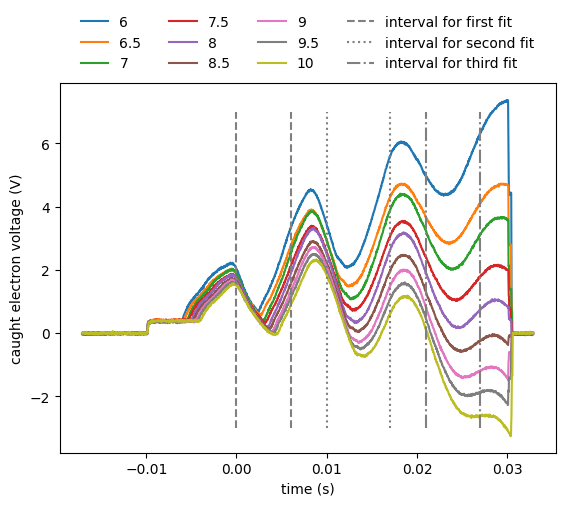

In [65]:
# plot all curves plus decided fit range
#avgs.insert(0, "time", np.tile(np.array(data["x-axis"]), len(vals)))
ax = sns.lineplot(avgs, x = "time", y = "mean_1", hue = "finvolt")
plt.vlines(intervals["1"], -3, 7, color = "grey", ls = "--", label = "interval for first fit")
plt.vlines(intervals["2"], -3, 7, color = "grey", ls = ":", label = "interval for second fit")
plt.vlines(intervals["3"], -3, 7, color = "grey", ls = "-.", label = "interval for third fit")
plt.xlabel("time (s)")
plt.ylabel("caught electron voltage (V)")
plt.legend()
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor = (.5, 1), ncol = 4, title = None, frameon = False,
)